In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import seaborn
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import transforms

In [3]:
from torch.utils.data import TensorDataset
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader

In [4]:
class Trainer:

    def __init__(self,
                 model: torch.nn.Module,
                 device: torch.device,
                 criterion: torch.nn.Module,
                 optimizer: torch.optim.Optimizer,
                 training_DataLoader: torch.utils.data.Dataset,
                 validation_DataLoader: None,
                 # lr_scheduler: torch.optim.lr_scheduler = None,
                 epochs: int = 100,
                 epoch: int = 0,
                 notebook: bool = False,
                 path2write: str = None,
                 save_best=False,
                 save_final=True,
                 save_interval=10,
                 checkpoint_start_epoch=50
                 ):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        # self.lr_scheduler = lr_scheduler
        self.training_DataLoader = training_DataLoader
        self.validation_DataLoader = validation_DataLoader
        self.device = device
        self.epochs = epochs
        self.epoch = epoch
        self.notebook = notebook
        self.path2write = path2write
        LOG_DIR = os.path.join(path2write, 'Log')  # path2write + 'Log/'
        self.writer_train = SummaryWriter(os.path.join(LOG_DIR, "train"))
        self.writer_val = SummaryWriter(os.path.join(LOG_DIR, "val"))
        self.check_point_path = os.path.join(path2write, 'check_points')
        if not os.path.exists(self.check_point_path):
            os.makedirs(self.check_point_path)
        self.save_best = save_best
        self.save_final = save_final
        self.save_interval = save_interval
        self.checkpoint_start_epoch = checkpoint_start_epoch
        self.training_loss = []
        self.validation_loss = []
        self.learning_rate = []
        self.training_accuracy = []
        self.validation_accuracy = []

    def run_trainer(self):
        self.model.to(self.device)
        #         print(next(self.model.parameters()).device)
        if self.notebook:
            print('Notebook')
            from tqdm.notebook import tqdm, trange
        else:
            from tqdm import tqdm, trange
        #         print(self.epochs)
        progressbar = trange(self.epochs, desc='Progress', disable=True)  # don't show progressbar
        loss_max = None
        for epoch in progressbar:
            # print(f'Epoch - {epoch}')

            # Training Block
            train_loss, train_accuracy = self._train()
            self.writer_train.add_scalar("Train Loss", train_loss, epoch)
            self.writer_train.add_scalar("Train Accuracy", train_accuracy, epoch)


            # Val Block
            val_loss, val_accuracy = self._validate()
            self.writer_val.add_scalar("Val Loss", val_loss, epoch)
            self.writer_val.add_scalar("Val Accuracy", val_accuracy, epoch)

            # lr
            self.writer_train.add_scalar("Learning Rate", self.optimizer.param_groups[0]['lr'], epoch)

            # print('Epoch - {} Train Loss - {:.6f} Val Loss - {:.6f} Train Accuracy - {:.6f} Val Accuracy - {:.6f}'.format(epoch, train_loss, val_loss, train_accuracy, val_accuracy))
            if self.save_final:
                if epoch == self.epochs-1:
                    model_name = 'epoch-{}-loss{:.6f}'.format(epoch, val_loss)
                    torch.save(self.model.state_dict(), os.path.join(self.check_point_path, model_name))
            loss_max = val_loss

        return train_loss, train_accuracy, val_loss, val_accuracy
        # return self.training_loss, self.validation_loss, self.model, self.training_accuracy, self.validation_accuracy

    def _train(self):

        self.model.train()
        train_losses = []
        batch_iter = tqdm(enumerate(self.training_DataLoader), 'Training', total=len(self.training_DataLoader),
                          disable=True)
        batch_acc = 0
        for i, (x, y) in batch_iter:
            input, target = x.type(torch.float32).to(self.device), y.type(torch.float32).to(self.device)
            self.optimizer.zero_grad()
            target = target.type(torch.LongTensor).to(self.device)
            output = self.model(input)
            loss = self.criterion(output, target)
            train_losses.append(loss.item())
            loss.backward()
            self.optimizer.step()
            pred = output.argmax(dim=1, keepdim=True) # max of prob
            pred = pred.flatten()
            batch_acc += torch.mean(pred.eq(target.view_as(pred)).type(torch.FloatTensor))
        accuracy = batch_acc/len(self.training_DataLoader)
        self.training_loss.append(np.mean(train_losses))  # Mean batch loss
        self.learning_rate.append(self.optimizer.param_groups[0]['lr'])
        self.training_accuracy.append(accuracy)

        batch_iter.close()  # clean up the bar
        return np.mean(train_losses), accuracy

    def _validate(self):

        self.model.eval()
        valid_losses = []
        batch_iter = tqdm(enumerate(self.validation_DataLoader), 'validation', total=len(self.validation_DataLoader), disable=True)
        batch_acc = 0
        for i, (x, y) in batch_iter:
            input, target = x.type(torch.float32).to(self.device), y.to(self.device)
            with torch.no_grad():
                output = self.model(input)
                target = target.type(torch.LongTensor).to(self.device)
                loss = self.criterion(output, target)
                valid_losses.append(loss.item())
                pred = output.argmax(dim=1, keepdim=True)
                batch_acc += torch.mean(pred.eq(target.view_as(pred)).type(torch.FloatTensor)).item()

        accuracy = batch_acc/len(self.validation_DataLoader)
        self.validation_loss.append(np.mean(valid_losses))
        self.validation_accuracy.append(accuracy)
        batch_iter.close()
        return np.mean(valid_losses), accuracy

In [5]:
class scale_DNN(nn.Module): #for mnist
  def __init__(self, start_num):
    super().__init__()
    self.Dense1 = nn.Linear(28*28, start_num)
    self.Dense2 = nn.Linear(start_num, start_num*2)
    self.Dense3 = nn.Linear(start_num*2, start_num*4)
    self.Dense4 = nn.Linear(start_num*4, start_num*8)
    self.Dense5 = nn.Linear(start_num*8, 10)

  def forward(self, x):
    x = x.view(x.shape[0], -1)
    x = self.Dense1(x)
    x = self.Dense2(x)
    x = self.Dense3(x)
    x = self.Dense4(x)
    x = self.Dense5(x)
    out = F.log_softmax(x)

    return out

In [6]:
bath_size = 4096*6

In [7]:
from torchvision import transforms, datasets


In [8]:
transform=transforms.Compose([
        transforms.ToTensor()
        ])
dataset1 = datasets.MNIST('Home work', train=True, download=True, transform=transform)
dataset2 = datasets.MNIST('Home work', train=False, transform=transform)

In [9]:
training_DataLoader = DataLoader(dataset1, batch_size=bath_size, shuffle=True)
validation_DataLoader= DataLoader(dataset2, batch_size=bath_size, shuffle=True)

In [10]:
gpu_id = 0
loss_fn = nn.CrossEntropyLoss()
lr = 1e-4
epochs = 15
notebook = True
checkpoint_start_epoch = 1 #Not using
path2write = r"/Users/ramya/Desktop"

In [11]:
path2write = os.path.expanduser("~/my_logs")  # This will create a 'my_logs' directory in your home directory


In [12]:
parms = []
train_loss = []
val_loss = []
train_acc = []
val_acc = []
for i in tqdm(list(map(lambda x : x*8, range(1,16)))):
  model = scale_DNN(i)
  total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
  optimizer = torch.optim.Adam(model.parameters(), lr = lr)
  trainer = Trainer(model=model,
                        device=gpu_id,
                        criterion=loss_fn,
                        optimizer=optimizer,
                        training_DataLoader=training_DataLoader,
                        validation_DataLoader=validation_DataLoader,
                        # lr_scheduler=lr_scheduler,
                        epochs=epochs,
                        epoch=0,
                        notebook=True,
                        path2write= path2write,
                        checkpoint_start_epoch=checkpoint_start_epoch )
  training_loss, training_accuracy, validation_loss, validation_accuracy = trainer.run_trainer()
  parms.append(total_params)
  train_loss.append(training_loss)
  val_loss.append(validation_loss)
  train_acc.append(training_accuracy)
  val_acc.append(validation_accuracy)

  0%|          | 0/15 [00:00<?, ?it/s]

Notebook


/local_scratch/slurm.707385/ipykernel_657266/1284617082.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.log_softmax(x)
  7%|▋         | 1/15 [01:16<17:53, 76.64s/it]

Notebook


 13%|█▎        | 2/15 [02:32<16:27, 75.98s/it]

Notebook


 20%|██        | 3/15 [03:48<15:11, 75.93s/it]

Notebook


 27%|██▋       | 4/15 [05:03<13:51, 75.63s/it]

Notebook


 33%|███▎      | 5/15 [06:18<12:36, 75.65s/it]

Notebook


 40%|████      | 6/15 [07:34<11:19, 75.54s/it]

Notebook


 47%|████▋     | 7/15 [08:49<10:03, 75.43s/it]

Notebook


 53%|█████▎    | 8/15 [10:04<08:46, 75.24s/it]

Notebook


 60%|██████    | 9/15 [11:18<07:29, 74.91s/it]

Notebook


 67%|██████▋   | 10/15 [12:32<06:13, 74.79s/it]

Notebook


 73%|███████▎  | 11/15 [13:47<04:58, 74.72s/it]

Notebook


 80%|████████  | 12/15 [15:02<03:44, 74.75s/it]

Notebook


 87%|████████▋ | 13/15 [16:16<02:29, 74.53s/it]

Notebook


 93%|█████████▎| 14/15 [17:29<01:14, 74.21s/it]

Notebook


100%|██████████| 15/15 [18:43<00:00, 74.90s/it]


plt.subplots_adjust(bottom=0.15)

Text(150.09722222222223, 0.5, 'Loss')

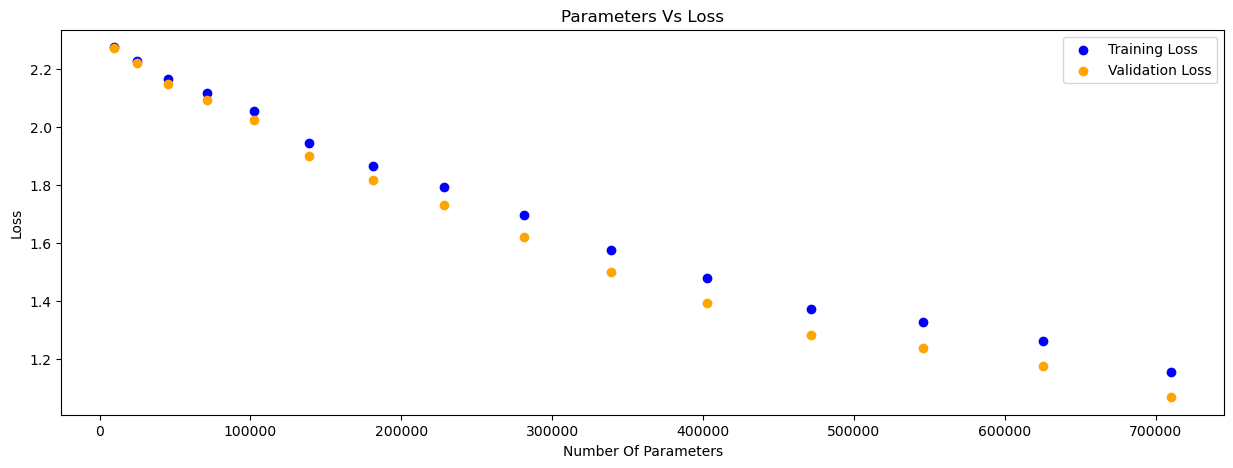

In [13]:
fig = plt.figure(figsize=(15,5))
fig.autolayout : True
ax1 = fig.add_subplot(1,1,1)
ax1.scatter(parms, train_loss, color='blue', marker='o', label='Training Loss')
ax1.scatter(parms, val_loss, color='orange', marker='o', label='Validation Loss')
ax1.legend()
ax1.set_title('Parameters Vs Loss')
fig.savefig(os.path.join(path2write, 'ParamsVsGen_loss.png'))
ax1.set_xlabel('Number Of Parameters')
ax1.set_ylabel('Loss')

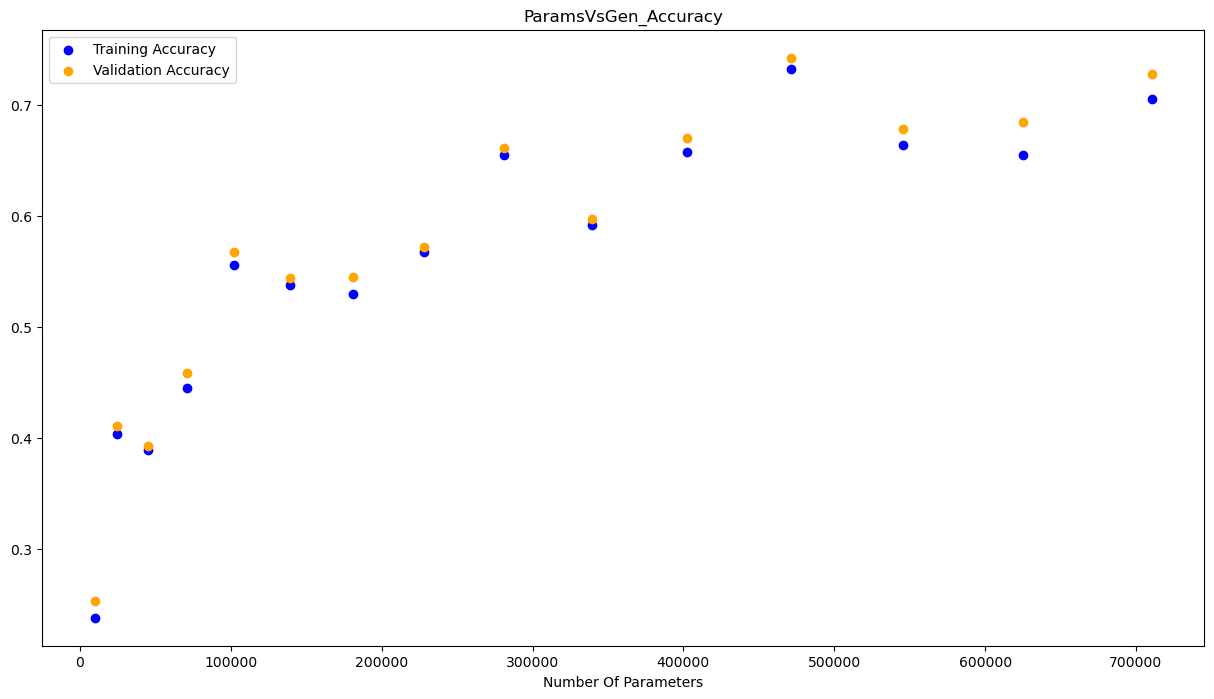

In [14]:
fig = plt.figure(figsize=(15,8))
fig.autolayout : True
ax2 = fig.add_subplot(1,1,1)
ax2.scatter(parms, train_acc, color='blue', marker='o', label='Training Accuracy')
ax2.scatter(parms, val_acc, color='orange', marker='o', label='Validation Accuracy')
ax2.legend()
ax2.set_title('ParamsVsGen_Accuracy')
fig.savefig(os.path.join(path2write, 'Params Vs accuracy.png'))
ax2.set_xlabel('Number Of Parameters')
ax2.set_label('Accuracy')

In [16]:
print('')
plt.show()